In [1]:
from dataclasses import dataclass, field
import copy
from enum import Enum, auto
import random
import pandas as pd
import seaborn as sns


import blackjack as bj
from blackjack import Hand, make_hand

In [2]:
h = Hand()
h

Hand(score=0, soft=False, cards=[], doubled=False)

In [3]:
h.add_card(6) # start a hand with a 6

Hand(score=6, soft=False, cards=[6], doubled=False)

In [4]:
h.add_card(11) # show that J (11) counts as 10 points

Hand(score=16, soft=False, cards=[6, 11], doubled=False)

In [5]:
h.add_card(7), bj.is_busted(h) # bust (show that 23 is counted as 22)

(Hand(score=22, soft=False, cards=[6, 11, 7], doubled=False), True)

In [6]:
# OK, now let's try another hand with aces
h = Hand()
h.add_card(1) # should be a soft 11

Hand(score=11, soft=True, cards=[1], doubled=False)

In [7]:
h.add_card(1) # two aces: should be a soft 12

Hand(score=12, soft=True, cards=[1, 1], doubled=False)

In [8]:
h.add_card(11) # two aces and a J: should be a hard 12

Hand(score=12, soft=False, cards=[1, 1, 11], doubled=False)

In [9]:
# OK, now let's try another hand with a blackjack
h = Hand()
h.add_card(1) # should be a soft 11
h.add_card(10)
h, bj.is_blackjack(h)

(Hand(score=21, soft=True, cards=[1, 10], doubled=False), True)

## Now define gameplay and strategy

In [10]:

# TODO I might want a Flag class later, to provide a set of possible Actions
class Action(Enum):
    STAND = auto()
    HIT = auto()
    DOUBLE = auto()
    #SPLIT = auto()
    
    

In [11]:
# Most simple/conservative strategy imaginable:
def strat_nobust(hand, dealer):
    if hand.score > 11:
        return Action.STAND
    else:
        return Action.HIT
        
strat_nobust.name = 'strat_nobust'

In [12]:
# Dealer strategy
def strat_dealer(hand, dealer):
    if hand.score < 17:
        return Action.HIT
    # TODO handle soft hands
    else:
        return Action.STAND
    
strat_dealer.name='strat_dealer'
        

In [13]:
class HandOutcome(Enum):
    WIN = 1
    LOSE = -1
    WIN_DOUBLE = 2
    LOSE_DOUBLE = -2
    PUSH = 0
    BLACKJACK = 1.5

In [14]:
# Deck; completely random (i.e., infinite) for now


def deal_card():
    return random.randrange(13)+1

In [15]:
[deal_card() for _ in range(10)]

[10, 13, 3, 8, 1, 11, 12, 10, 2, 10]

In [16]:
# return the final hand after playing
def player_play_hand(strategy, hand, dealer, deck):
    while True:
        decision = strategy(hand, dealer)
        if decision == Action.STAND:
            return hand
        if decision == Action.HIT:
            hand.add_card(deck())
            if bj.is_busted(hand):
                return hand
        if decision == Action.DOUBLE:
            hand.doubled = True
            hand.add_card(deck())
            return hand



In [17]:
def player_hand_outcome(player_hand, dealer_hand):
    # First compute the initial outcome, then double it if necessary for a double-down
    def initial_outcome():
        if bj.is_blackjack(player_hand):
            if bj.is_blackjack(dealer_hand):
                return HandOutcome.PUSH
            else:
                return HandOutcome.BLACKJACK
        if bj.is_busted(player_hand) or bj.is_blackjack(dealer_hand):
            return HandOutcome.LOSE
        if bj.is_busted(dealer_hand):
            return HandOutcome.WIN
        if player_hand.score > dealer_hand.score:
            return HandOutcome.WIN
        if player_hand.score == dealer_hand.score:
            return HandOutcome.PUSH
        if player_hand.score < dealer_hand.score:
            return HandOutcome.LOSE

    outcome = initial_outcome()

    outcome_doubler = {HandOutcome.WIN: HandOutcome.WIN_DOUBLE, HandOutcome.LOSE: HandOutcome.LOSE_DOUBLE}

    if player_hand.doubled:
        outcome = outcome_doubler.get(outcome) or outcome
    return outcome
        


In [18]:
def get_strat_name(strat):
    if hasattr(strat, 'name'):
        return strat.name
    return repr(strat)

In [19]:
# Goal is to evaluate strategies, so make comparisons simple

# For each round:
# Multiple players all play with a copy of the same starting hand
# Each player has a strategy that they play
# Dealer plays dealer strategy

# For now, we're using an infinite deck and strategies without knowledge, so
# the interaction of players/strategies should be a wash

def deal_one_round():
    hand_p = Hand()
    hand_d = Hand()

    hand_p.add_card(deal_card())
    hand_d.add_card(deal_card())
    hand_p.add_card(deal_card())
    
    dealer_hole_card = deal_card()
    
    return hand_p, hand_d, dealer_hole_card


# Play multiple strategies on one starting point
def complete_one_round(strats, player_hand, dealer_hand, dealer_hole_card):
    hand_p = copy.deepcopy(player_hand)
    hand_d = copy.deepcopy(dealer_hand)
    
    # represent each player as a hand and a strategy
    players = [(player_play_hand(strat, copy.deepcopy(hand_p), hand_d, deal_card), get_strat_name(strat)) for strat in strats]
    
    # dealer
    player_play_hand(strat_dealer, hand_d.add_card(dealer_hole_card), None, deal_card)
    
    return [(strat, hand_p, hand_d, player_hand_outcome(hand_p, hand_d)) for (hand_p, strat) in players]

    
def play_one_round(strats):
    hand_p, hand_d, dealer_hole_card = deal_one_round()
    return complete_one_round(strats, hand_p, hand_d, dealer_hole_card)

play_one_round([strat_nobust, strat_nobust])

[('strat_nobust',
  Hand(score=20, soft=False, cards=[6, 4, 10], doubled=False),
  Hand(score=19, soft=False, cards=[6, 7, 6], doubled=False),
  <HandOutcome.WIN: 1>),
 ('strat_nobust',
  Hand(score=19, soft=False, cards=[6, 4, 9], doubled=False),
  Hand(score=19, soft=False, cards=[6, 7, 6], doubled=False),
  <HandOutcome.PUSH: 0>)]

## Aggregate and summarize the data from the simulations

In [20]:

def generate_row_from_player(player):
    (strat, hand_p, hand_d, outcome) = player
    return {'strategy': strat, 'hand_start': hand_p.cards[:2], 'dealer_card': hand_d.cards[0], 'hand_end': hand_p.cards, 'dealer_hand': hand_d.cards, 'outcome': outcome}

def generate_rows_from_round(r):
    return [generate_row_from_player(player) for player in r]


generate_rows_from_round(play_one_round([strat_nobust, strat_dealer]))


[{'strategy': 'strat_nobust',
  'hand_start': [4, 3],
  'dealer_card': 5,
  'hand_end': [4, 3, 3, 13],
  'dealer_hand': [5, 13, 13],
  'outcome': <HandOutcome.WIN: 1>},
 {'strategy': 'strat_dealer',
  'hand_start': [4, 3],
  'dealer_card': 5,
  'hand_end': [4, 3, 11],
  'dealer_hand': [5, 13, 13],
  'outcome': <HandOutcome.WIN: 1>}]

In [21]:
def run_n_sim_trials(strats, n):
    sims = [generate_rows_from_round(play_one_round(strats)) for _ in range(n)]
    results = pd.DataFrame([player for round in sims for player in round])
    results['outcome_value'] = results['outcome'].apply(lambda x: x.value)
    results['outcome_name'] = results['outcome'].apply(lambda x: str(x)[12:])
    return results

def summarize_totals(sims):
    def outcome_name(x): return x.head(1) # The function name will be used as the column name
    outcome_counts = sims.groupby(['strategy', 'outcome_value'])['outcome_name'].agg([len, outcome_name])
    outcome_summary = outcome_counts.reset_index().set_index('strategy').drop(['outcome_value'], axis=1).pivot(columns=['outcome_name'])

    # The empty cells are NaNs; fill the NaNs and convert back to int
    for col in outcome_summary.columns:
        outcome_summary[col] = outcome_summary[col].fillna(0).apply(int)
        
    outcome_summary['mean_outcome'] = sims.groupby('strategy')['outcome_value'].mean()
    
    return outcome_summary


sim_results = run_n_sim_trials([strat_nobust, strat_dealer], 1000)
sim_results, summarize_totals(sim_results)

(          strategy hand_start  dealer_card          hand_end  dealer_hand  \
 0     strat_nobust    [6, 13]            2           [6, 13]  [2, 11, 10]   
 1     strat_dealer    [6, 13]            2        [6, 13, 3]  [2, 11, 10]   
 2     strat_nobust     [8, 3]            5         [8, 3, 8]  [5, 12, 10]   
 3     strat_dealer     [8, 3]            5      [8, 3, 5, 1]  [5, 12, 10]   
 4     strat_nobust     [5, 9]            5            [5, 9]    [5, 8, 7]   
 ...            ...        ...          ...               ...          ...   
 1995  strat_dealer    [8, 13]           12           [8, 13]   [12, 2, 5]   
 1996  strat_nobust     [1, 5]           11            [1, 5]     [11, 11]   
 1997  strat_dealer     [1, 5]           11  [1, 5, 2, 3, 10]     [11, 11]   
 1998  strat_nobust     [8, 8]           13            [8, 8]      [13, 9]   
 1999  strat_dealer     [8, 8]           13        [8, 8, 11]      [13, 9]   
 
                outcome  outcome_value outcome_name  
 0      

In [22]:
def strat_simple(hand, dealer):
    if hand.score == 11:  return Action.DOUBLE
    if hand.score >= 17:  return Action.STAND
    if hand.score <= 11:  return Action.HIT
    if dealer.score in (range(3,7)):  return Action.STAND
    else:  return Action.HIT
        
strat_simple.name = 'simple'


sims = run_n_sim_trials([strat_simple], 1000)
sims.head(10), summarize_totals(sims)

(  strategy hand_start  dealer_card          hand_end     dealer_hand  \
 0   simple     [5, 7]           10        [5, 7, 10]     [10, 6, 13]   
 1   simple     [4, 7]           10         [4, 7, 7]        [10, 12]   
 2   simple     [9, 2]            5         [9, 2, 9]   [5, 4, 5, 13]   
 3   simple     [1, 1]            5            [1, 1]       [5, 8, 6]   
 4   simple    [5, 11]            9        [5, 11, 7]         [9, 13]   
 5   simple    [13, 5]            8        [13, 5, 2]      [8, 8, 12]   
 6   simple     [5, 4]            8  [5, 4, 3, 1, 12]       [8, 2, 7]   
 7   simple    [9, 10]            7           [9, 10]      [7, 4, 12]   
 8   simple    [9, 11]            1           [9, 11]         [1, 13]   
 9   simple     [8, 9]            4            [8, 9]  [4, 2, 12, 11]   
 
                    outcome  outcome_value outcome_name  
 0         HandOutcome.LOSE           -1.0         LOSE  
 1  HandOutcome.LOSE_DOUBLE           -2.0  LOSE_DOUBLE  
 2   HandOutcome.WIN_

In [23]:
summarize_totals(run_n_sim_trials([strat_dealer, strat_nobust, strat_simple], 10000))


len                                         mean_outcome
outcome_name BLACKJACK  LOSE LOSE_DOUBLE PUSH   WIN WIN_DOUBLE             
strategy                                                                   
simple             461  4613         261  868  3477        320     -0.03265
strat_dealer       461  4986           0  990  3563          0     -0.07315
strat_nobust       461  5206           0  625  3708          0     -0.08065

## Simulate specific situations to determine strategy

In [24]:
# 12 vs deuce

hand_p = bj.make_hand([5, 7])
hand_d = bj.make_hand([2])

hand_p, hand_d

(Hand(score=12, soft=False, cards=[5, 7], doubled=False),
 Hand(score=2, soft=False, cards=[2], doubled=False))

In [25]:
# Implement a strategy that composes conditions and actions

def cond_12_2(hand, dealer):
    return hand.score == 12 and dealer.score == 2 and not hand.soft
conditions = [(cond_12_2, Action.STAND)]

def generate_strat_conditional(strat_base, conditions):
    def strat_cond(hand, dealer):
        for (condition, action) in conditions:
            if condition(hand, dealer): return action
        return strat_base(hand, dealer)
    strat_cond.name = 'strat_cond'
    return strat_cond
    
strat_cond = generate_strat_conditional(strat_simple, conditions)

In [26]:
def gen_cond_strategies(strat_base, condition, actions):
    def gen_strat_action(strat_base, condition, action):
        strat = generate_strat_conditional(strat_base, [(condition, action)])
        strat.name = repr(action)
        return strat
    
    strats = [gen_strat_action(strat_base, condition, a) for a in actions]
    return strats
    



strats = gen_cond_strategies(strat_simple, cond_12_2, [Action.HIT, Action.STAND, Action.DOUBLE])
strats

[<function __main__.generate_strat_conditional.<locals>.strat_cond(hand, dealer)>,
 <function __main__.generate_strat_conditional.<locals>.strat_cond(hand, dealer)>,
 <function __main__.generate_strat_conditional.<locals>.strat_cond(hand, dealer)>]

In [27]:
complete_one_round(strats, hand_p, hand_d, deal_card())

[('<Action.HIT: 2>',
  Hand(score=17, soft=False, cards=[5, 7, 5], doubled=False),
  Hand(score=22, soft=False, cards=[2, 2, 4, 6, 2, 11], doubled=False),
  <HandOutcome.WIN: 1>),
 ('<Action.STAND: 1>',
  Hand(score=12, soft=False, cards=[5, 7], doubled=False),
  Hand(score=22, soft=False, cards=[2, 2, 4, 6, 2, 11], doubled=False),
  <HandOutcome.WIN: 1>),
 ('<Action.DOUBLE: 3>',
  Hand(score=14, soft=False, cards=[5, 7, 2], doubled=True),
  Hand(score=22, soft=False, cards=[2, 2, 4, 6, 2, 11], doubled=False),
  <HandOutcome.WIN_DOUBLE: 2>)]

In [28]:
# TODO reduce duplication with run_n_sim_trials
def run_n_sim_trials_from_state(strats, hand_p, hand_d, n):
    sims = [generate_rows_from_round(complete_one_round(strats, hand_p, hand_d, deal_card())) for _ in range(n)]
    results = pd.DataFrame([player for round in sims for player in round])
    results['outcome_value'] = results['outcome'].apply(lambda x: x.value)
    results['outcome_name'] = results['outcome'].apply(lambda x: str(x)[12:])
    return results

sims = run_n_sim_trials_from_state(strats, hand_p, hand_d, 10000)
summarize_totals(sims)

len                                   mean_outcome
outcome_name        LOSE LOSE_DOUBLE PUSH   WIN WIN_DOUBLE             
strategy                                                               
<Action.DOUBLE: 3>     0        6046  475     0       3479      -0.5134
<Action.HIT: 2>     6075           0  683  3242          0      -0.2833
<Action.STAND: 1>   6365           0    0  3635          0      -0.2730

In [29]:
# Soft 12 vs 2
hand_12s = bj.make_hand([1, 1])

hand_12s, hand_d

(Hand(score=12, soft=True, cards=[1, 1], doubled=False),
 Hand(score=2, soft=False, cards=[2], doubled=False))

In [30]:
def cond_12s_2(hand, dealer):
    return hand.score == 12 and dealer.score == 2 and hand.soft

strats = gen_cond_strategies(strat_simple, cond_12s_2, [Action.HIT, Action.STAND, Action.DOUBLE])
strats

[<function __main__.generate_strat_conditional.<locals>.strat_cond(hand, dealer)>,
 <function __main__.generate_strat_conditional.<locals>.strat_cond(hand, dealer)>,
 <function __main__.generate_strat_conditional.<locals>.strat_cond(hand, dealer)>]

In [31]:
sims = run_n_sim_trials_from_state(strats+[strat_simple], hand_12s, hand_d, 10000)
summarize_totals(sims)

len                                   mean_outcome
outcome_name        LOSE LOSE_DOUBLE PUSH   WIN WIN_DOUBLE             
strategy                                                               
<Action.DOUBLE: 3>     0        6360    0     0       3640      -0.5440
<Action.HIT: 2>     4815         440  760  3256        729      -0.0981
<Action.STAND: 1>   6360           0    0  3640          0      -0.2720
simple              4870         419  776  3166        769      -0.1004

In [32]:
summarize_totals(run_n_sim_trials_from_state([strat_simple, strat_cond], hand_p, hand_d, 100*1000))

len              mean_outcome
outcome_name   LOSE  PUSH    WIN             
strategy                                     
simple        60851  6551  32598     -0.28253
strat_cond    63711     0  36289     -0.27422

In [33]:
# soft 13 vs 6
def cond_13s_6(hand, dealer):
    return hand.score == 13 and dealer.score == 6 and hand.soft



strats = gen_cond_strategies(strat_simple, cond_13s_6, [Action.HIT, Action.STAND, Action.DOUBLE])
sims = run_n_sim_trials_from_state(strats+[strat_simple], bj.make_hand([1, 2]), bj.make_hand([6]), 100000)
summarize_totals(sims)

len                                     mean_outcome
outcome_name         LOSE LOSE_DOUBLE  PUSH    WIN WIN_DOUBLE             
strategy                                                                  
<Action.DOUBLE: 3>      0       57809     0      0      42191     -0.31236
<Action.HIT: 2>     45425        3262  2974  41293       7046      0.03436
<Action.STAND: 1>   57809           0     0  42191          0     -0.15618
simple              57809           0     0  42191          0     -0.15618

In [34]:
# 10 v 6
def cond_10_6(hand, dealer):
    return hand.score == 10 and dealer.score == 6 and not hand.soft

strats = gen_cond_strategies(strat_simple, cond_10_6, [Action.HIT, Action.STAND, Action.DOUBLE])
sims = run_n_sim_trials_from_state(strats+[strat_simple], make_hand([5, 5]), make_hand([6]), 10000)
summarize_totals(sims)

len                                   mean_outcome
outcome_name        LOSE LOSE_DOUBLE PUSH   WIN WIN_DOUBLE             
strategy                                                               
<Action.DOUBLE: 3>     0        3259  654     0       6087       0.5656
<Action.HIT: 2>     3241           0  687  6072          0       0.2831
<Action.STAND: 1>   5826           0    0  4174          0      -0.1652
simple              3206           0  713  6081          0       0.2875

In [35]:
ACTIONS = [Action.HIT, Action.STAND, Action.DOUBLE]

def test_cond(score_p, score_d, n):
    def cond(h, d):
        return h.score == score_p and d.score == score_d
    strats = gen_cond_strategies(strat_simple, cond, ACTIONS)
    hand = make_hand([8, score_p-8]) # This will only work for 10 through 18 
    sims = run_n_sim_trials_from_state(strats, hand, make_hand([score_d]), n)
    return cond, summarize_totals(sims)

test_cond(10, 6, 200)

(<function __main__.test_cond.<locals>.cond(h, d)>,
                     len                                  mean_outcome
 outcome_name       LOSE LOSE_DOUBLE PUSH  WIN WIN_DOUBLE             
 strategy                                                             
 <Action.DOUBLE: 3>    0          66   18    0        116         0.50
 <Action.HIT: 2>      65           0   22  113          0         0.24
 <Action.STAND: 1>   115           0    0   85          0        -0.15)

In [36]:
def find_winning_action(score_p, score_d, n):
    cond, summary = test_cond(score_p, score_d, n)
    outcomes = summary['mean_outcome']
    # Find the winning strategy
    winner = outcomes[outcomes==outcomes.max()].index[0]
    winning_act = [a for a in ACTIONS if repr(a)==winner][0]

    # Convert results to a dict
    run = outcomes.to_dict()
    run['score_p'] = score_p
    run['score_d'] = score_d
    run['winning_act'] = winning_act
    run['winning_act_outcome'] = outcomes.max()

    return (cond, run)

find_winning_action(10, 6, 200)

(<function __main__.test_cond.<locals>.cond(h, d)>,
 {'<Action.DOUBLE: 3>': 0.28,
  '<Action.HIT: 2>': 0.25,
  '<Action.STAND: 1>': -0.23,
  'score_p': 10,
  'score_d': 6,
  'winning_act': <Action.DOUBLE: 3>,
  'winning_act_outcome': 0.28})

In [37]:
conds = [find_winning_action(p, d, 10) for p in range(10, 11) for d in range(1, 3)]
pd.DataFrame([data for _, data in conds]).set_index(['score_p', 'score_d'])

<Action.DOUBLE: 3>  <Action.HIT: 2>  <Action.STAND: 1>  \
score_p score_d                                                           
10      1                       0.1             -0.2               -0.5   
        2                      -1.2              0.1               -0.8   

                   winning_act  winning_act_outcome  
score_p score_d                                      
10      1        Action.DOUBLE                  0.1  
        2           Action.HIT                  0.1

In [38]:
conds = [find_winning_action(p, d, 100*1000) for p in range(10, 19) for d in range(2, 11)]
conds

[(<function __main__.test_cond.<locals>.cond(h, d)>,
  {'<Action.DOUBLE: 3>': 0.3877,
   '<Action.HIT: 2>': 0.15444,
   '<Action.STAND: 1>': -0.26922,
   'score_p': 10,
   'score_d': 2,
   'winning_act': <Action.DOUBLE: 3>,
   'winning_act_outcome': 0.3877}),
 (<function __main__.test_cond.<locals>.cond(h, d)>,
  {'<Action.DOUBLE: 3>': 0.43644,
   '<Action.HIT: 2>': 0.21752,
   '<Action.STAND: 1>': -0.23476,
   'score_p': 10,
   'score_d': 3,
   'winning_act': <Action.DOUBLE: 3>,
   'winning_act_outcome': 0.43644}),
 (<function __main__.test_cond.<locals>.cond(h, d)>,
  {'<Action.DOUBLE: 3>': 0.48452,
   '<Action.HIT: 2>': 0.24156,
   '<Action.STAND: 1>': -0.19304,
   'score_p': 10,
   'score_d': 4,
   'winning_act': <Action.DOUBLE: 3>,
   'winning_act_outcome': 0.48452}),
 (<function __main__.test_cond.<locals>.cond(h, d)>,
  {'<Action.DOUBLE: 3>': 0.52946,
   '<Action.HIT: 2>': 0.26484,
   '<Action.STAND: 1>': -0.15932,
   'score_p': 10,
   'score_d': 5,
   'winning_act': <Action.DOU

In [39]:
outputs = pd.DataFrame([data for _, data in conds]).set_index(['score_p', 'score_d'])
outputs

<Action.DOUBLE: 3>  <Action.HIT: 2>  <Action.STAND: 1>  \
score_p score_d                                                           
10      2                   0.38770          0.15444           -0.26922   
        3                   0.43644          0.21752           -0.23476   
        4                   0.48452          0.24156           -0.19304   
        5                   0.52946          0.26484           -0.15932   
        6                   0.56378          0.28794           -0.15500   
...                             ...              ...                ...   
18      6                  -1.21936         -0.60454            0.28456   
        7                  -1.17954         -0.59194            0.40141   
        8                  -1.17918         -0.58634            0.10364   
        9                  -1.22594         -0.61822           -0.18295   
        10                 -1.34586         -0.67302           -0.23871   

                   winning_act  winning_act_outcome  
score_p score_d                                      
10      2        Action.DOUBLE              0.38770  
        3        Action.DOUBLE              0.43644  
        4        Action.DOUBLE              0.48452  
        5        Action.DOUBLE              0.52946  
        6        Action.DOUBLE              0.56378  
...                        ...                  ...  
18      6         Action.STAND              0.28456  
        7         Action.STAND              0.40141  
        8         Action.STAND              0.10364  
        9         Action.STAND             -0.18295  
        10        Action.STAND             -0.23871  

[81 rows x 5 columns]

<AxesSubplot:xlabel='score_d', ylabel='score_p'>

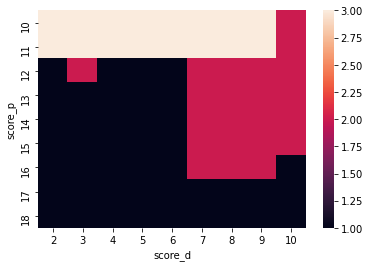

In [40]:
# Visualize the winning action by starting condition
sns.heatmap(outputs['winning_act'].apply(lambda x: x.value).unstack())


<AxesSubplot:xlabel='score_d', ylabel='score_p'>

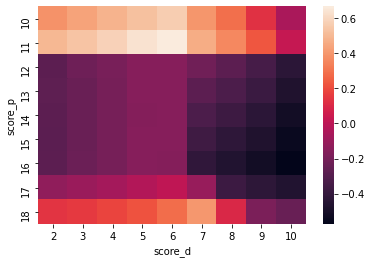

In [41]:
# Visualize the average outcome by starting condition
sns.heatmap(outputs['winning_act_outcome'].unstack())

In [42]:
[(cond, output['winning_act']) for cond, output in conds]

[(<function __main__.test_cond.<locals>.cond(h, d)>, <Action.DOUBLE: 3>),
 (<function __main__.test_cond.<locals>.cond(h, d)>, <Action.DOUBLE: 3>),
 (<function __main__.test_cond.<locals>.cond(h, d)>, <Action.DOUBLE: 3>),
 (<function __main__.test_cond.<locals>.cond(h, d)>, <Action.DOUBLE: 3>),
 (<function __main__.test_cond.<locals>.cond(h, d)>, <Action.DOUBLE: 3>),
 (<function __main__.test_cond.<locals>.cond(h, d)>, <Action.DOUBLE: 3>),
 (<function __main__.test_cond.<locals>.cond(h, d)>, <Action.DOUBLE: 3>),
 (<function __main__.test_cond.<locals>.cond(h, d)>, <Action.DOUBLE: 3>),
 (<function __main__.test_cond.<locals>.cond(h, d)>, <Action.HIT: 2>),
 (<function __main__.test_cond.<locals>.cond(h, d)>, <Action.DOUBLE: 3>),
 (<function __main__.test_cond.<locals>.cond(h, d)>, <Action.DOUBLE: 3>),
 (<function __main__.test_cond.<locals>.cond(h, d)>, <Action.DOUBLE: 3>),
 (<function __main__.test_cond.<locals>.cond(h, d)>, <Action.DOUBLE: 3>),
 (<function __main__.test_cond.<locals>.c

In [43]:
strat_derived = generate_strat_conditional(strat_simple, [(cond, output['winning_act']) for cond, output in conds])
strat_derived.name = 'strat_derived'

In [44]:
sims = run_n_sim_trials([strat_simple, strat_derived], 100)
sims.head(10), summarize_totals(sims)

(        strategy hand_start  dealer_card            hand_end   dealer_hand  \
 0         simple    [11, 8]            6             [11, 8]    [6, 9, 12]   
 1  strat_derived    [11, 8]            6             [11, 8]    [6, 9, 12]   
 2         simple    [10, 6]            4             [10, 6]  [4, 1, 3, 9]   
 3  strat_derived    [10, 6]            4             [10, 6]  [4, 1, 3, 9]   
 4         simple     [1, 4]            4              [1, 4]  [4, 9, 1, 6]   
 5  strat_derived     [1, 4]            4              [1, 4]  [4, 9, 1, 6]   
 6         simple     [7, 2]           10  [7, 2, 3, 2, 2, 8]       [10, 8]   
 7  strat_derived     [7, 2]           10        [7, 2, 3, 6]       [10, 8]   
 8         simple     [7, 1]           12              [7, 1]    [12, 5, 9]   
 9  strat_derived     [7, 1]           12              [7, 1]    [12, 5, 9]   
 
             outcome  outcome_value outcome_name  
 0   HandOutcome.WIN            1.0          WIN  
 1   HandOutcome.WIN       

In [46]:
sims = run_n_sim_trials([strat_simple, strat_derived], 1000*1000)
sims.head(10), summarize_totals(sims)

(        strategy hand_start  dealer_card    hand_end    dealer_hand  \
 0         simple    [7, 13]           13     [7, 13]        [13, 8]   
 1  strat_derived    [7, 13]           13     [7, 13]        [13, 8]   
 2         simple    [13, 5]            6     [13, 5]      [6, 7, 8]   
 3  strat_derived    [13, 5]            6     [13, 5]      [6, 7, 8]   
 4         simple     [6, 6]            3      [6, 6]   [3, 1, 6, 9]   
 5  strat_derived     [6, 6]            3  [6, 6, 10]   [3, 1, 6, 9]   
 6         simple   [10, 13]            3    [10, 13]  [3, 2, 13, 9]   
 7  strat_derived   [10, 13]            3    [10, 13]  [3, 2, 13, 9]   
 8         simple   [12, 12]            9    [12, 12]         [9, 9]   
 9  strat_derived   [12, 12]            9    [12, 12]         [9, 9]   
 
             outcome  outcome_value outcome_name  
 0  HandOutcome.LOSE           -1.0         LOSE  
 1  HandOutcome.LOSE           -1.0         LOSE  
 2  HandOutcome.LOSE           -1.0         LOSE  
 3